In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx

In [3]:
def load_results_new(models, experiments, base_dir, ext=''):
    results = dict()
    bird_scales = dict()
    all_fluxes = dict()
    att = dict()
    radar_idx = dict()
    for i, m in enumerate(models):
    
        experiment = experiments[i]

        # load predictions
        model_dir = osp.join(base_dir, 'training+testing', m, experiment)
        print(model_dir)
#         results[m] = pd.read_csv(osp.join(model_dir, 'results.csv'))

        files = glob.glob(model_dir + f"/**/results{ext}.csv", recursive = True)
        result_list = []
        for r, file in enumerate(files):
            df = pd.read_csv(file)
            if 'trial' not in df.columns:
                df['trial'] = r
            result_list.append(df)
        results[m] = pd.concat(result_list)

        # load bird scales
        fp = osp.join(osp.dirname(files[0]), 'config.yaml')
        with open(fp) as f:
            cfg = load(f, Loader=Loader)
        bird_scales[m] = cfg['datasource']['bird_scale']
        
        file = osp.join(osp.dirname(files[0]), 'radar_index.pickle')
        if osp.isfile(file):
            with open(file, 'rb') as f:
                radar_idx[m] = pickle.load(f)
        else:
            radar_idx[m] = {}
        
        if 'BirdFluxGraphLSTM' in m or m == 'testFluxMLP':
            fluxes = [dict(), dict(), dict()]
            files = glob.glob(model_dir + f"/**/local_fluxes{ext}.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[0][r] = pickle.load(f)
            files = glob.glob(model_dir + f"/**/radar_fluxes{ext}.pickle", recursive = True)
            print(len(files))
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[1][r] = pickle.load(f)
            files = glob.glob(model_dir + f"/**/radar_mtr{ext}.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[2][r] = pickle.load(f)
            all_fluxes[m] = fluxes
        if m == 'AttentionGraphLSTM':
            files = glob.glob(model_dir + f"/**/attention_weights{ext}.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    att[r] = pickle.load(f)
    return results, bird_scales, all_fluxes, att, radar_idx

In [29]:
def compare_fluxes_radar(voronoi, G, results, fluxes_model, fluxes_radar, trial=0, encoder=1, context=0, bird_scales={}, m='BirdFluxGraphLSTM', horizon=40):

    bird_scale = bird_scales.get(m, 1)
    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f_radar = torch.cat([f[..., context:context+horizon-1] for f in fluxes_radar[trial].values()], dim=-1)
    f_model = torch.cat([f[..., 1:horizon] for f in fluxes_model[trial].values()], dim=-1)
    print(f_radar.shape, f_model.shape)
    
    with sb.color_palette("Spectral", n_colors=40):
        fig1, ax1 = plt.subplots(figsize=(10,10))
        radars = results[m].radar.unique()
        for i, ri in enumerate(radars):
            for j, rj in enumerate(radars):
                val1 = f_model[j,i,:].detach().numpy().flatten()
                val2 = f_model[i,j,:].detach().numpy().flatten()
                fm = val1 - val2
                fr = f_radar[j,i,:].detach().numpy().flatten()
                if np.nanmean(fm) != 0:
                    boundary1 = ('boundary' in ri) and ('boundary' in rj)
                    boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()

                    if not boundary1 and not boundary2:
                        #G_new.add_edge(j, i, flux=val * bird_scale)
                        sc = ax1.scatter(fr, fm, alpha=0.5, label=f'{ri} - {rj}')

    ax1.set(xlabel='radar fluxes', ylabel='model fluxes');
    #ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    weight = np.square(f_radar.detach().numpy())
    rmse = (weight * (f_radar.detach().numpy() - f_model.detach().numpy())).mean()
    
    print(f'RMSE = {rmse}')
    return fig1

In [5]:
def plot_fluxes(voronoi, G, all_fluxes, results, trial=0, encoder=0, context=0, bird_scale=1):

    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f[..., context:] for f in all_fluxes[trial].values()], dim=-1)
    mask = np.concatenate([results.query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes[trial]))])


    radars = results.radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i,mask].detach().numpy()) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask].detach().numpy())
            #print(val)
            if val != 0:
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                #if val > 0 and not boundary1 and not boundary2:
#                 if not boundary1 and not boundary2:
#                     print(i, ri, j, rj, val, val2)
                if not boundary1 and not boundary2:
                    G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    norm = plt.Normalize(fluxes.min(), fluxes.max())
    edge_colors = cmap(norm(fluxes))

    fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    ax.set(title='averaged inferred fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new, fig

In [20]:
def plot_example(results, bird_scales, m, seqID, radar, trial=None):

    fig, ax = plt.subplots(figsize=(15, 6))

    r = results[m].query(f'seqID == {seqID} & radar == "{radar}"')
    if trial is not None:
        r = r.query(f'trial == {trial}')
    else:
        trial = 1

    r0 = r.query(f'trial == {trial}')
    ax.plot(range(len(r0)), r0['gt'] / bird_scales[m], label='radar observation', color='gray', ls='--')

    all_predictions = []
    all_deltas = []
    all_fluxes = []
    for trial in r.trial.unique():
        r_t = r.query(f'trial == {trial}')
        all_predictions.append(r_t['prediction'] / bird_scales[m])
        
        if 'Flux' in m:
            all_deltas.append(r_t['local_deltas'])
            all_fluxes.append(r_t['fluxes'])

    all_predictions = np.stack(all_predictions, axis=0)
    
    line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
    ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                    all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)
    
    if 'Flux' in m:
        all_deltas = np.stack(all_deltas, axis=0) #* 10
        all_fluxes = np.stack(all_fluxes, axis=0)

        ax.bar(np.arange(all_fluxes.shape[1]), all_deltas.mean(0), width=1, yerr=all_deltas.std(0), alpha=0.3, label='take-off/landing', color='green')
        ax.bar(np.arange(all_fluxes.shape[1]), all_fluxes.mean(0), width=1, yerr=all_fluxes.std(0), alpha=0.3, label='spatial fluxes', color='darkred')

    ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
    plt.legend()

In [7]:
def plot_classification_performance(results, thr, metric='specificity'):
    
    fig, ax = plt.subplots(figsize=(10, 4))
    
    for m in results.keys():
        df = results[m].query('missing == False')
        df['tp'] = (df.prediction_km2 > thr) & (df.gt_km2 > thr)
        df['fp'] = (df.prediction_km2 > thr) & (df.gt_km2 < thr)
        df['fn'] = (df.prediction_km2 < thr) & (df.gt_km2 > thr)
        df['tn'] = (df.prediction_km2 < thr) & (df.gt_km2 < thr)

        gr = df.groupby(['horizon', 'trial']).aggregate(sum).reset_index()
        if metric == 'accuracy':
            gr['metric'] = (gr.tp + gr.tn) / (gr.tp + gr.fp + gr.tn + gr.fn)
        elif metric == 'precision':
            gr['metric'] = gr.tp / (gr.tp + gr.fp)
        elif metric == 'recall':
            gr['metric'] = gr.tp / (gr.tp + gr.fn)
        elif metric == 'specificity':
            gr['metric'] = gr.tn / (gr.tn + gr.fp)
        elif metric == 'fscore':
            gr['metric'] = 2 / ((1 / gr.precision) + (1 / gr.recall))
        gr_mean = gr.groupby('horizon').aggregate(np.nanmean).reset_index()
        gr_std = gr.groupby('horizon').aggregate(np.nanstd).reset_index()
        gr_mean = gr_mean.fillna(0)
        gr_std = gr_std.fillna(0)


        l = ax.plot(gr_mean.horizon.values, gr_mean.metric.values, label=m)
        ax.fill_between(gr_mean.index, gr_mean.metric.values + gr_std.metric.values, gr_mean.metric.values - gr_std.metric.values, alpha=0.2, color=l[0].get_color())

    ax.set(xlabel='forecast horizon', ylabel=metric, ylim=(-0.05 ,1.05))
    ax.legend()
    #fig.savefig('/home/fiona/birdMigration/data/plots/presentations/performance_BirdFlux_classification_thr20_horizon64.png', bbox_inches='tight', dpi=300)

In [26]:
base_dir = '/home/fiona/birdMigration/results/radar'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
boundary = voronoi.query('boundary == True').radar.values
inner_idx = voronoi.query('boundary == False').index.values

In [25]:
models = ['LocalLSTM',
    'BirdFluxGraphLSTM',
          'BirdFluxGraphLSTM_boundaryExtrapolation']
experiments = ['array_job_7864944',
    'array_job_7864915',
    'array_job_7864073']
results, bird_scales, fluxes, _, _ = load_results_new(models, experiments, base_dir)#, ext='_no_nights')

/home/fiona/birdMigration/results/radar/training+testing/LocalLSTM/array_job_7864944
/home/fiona/birdMigration/results/radar/training+testing/BirdFluxGraphLSTM/array_job_7864915
5
/home/fiona/birdMigration/results/radar/training+testing/BirdFluxGraphLSTM_boundaryExtrapolation/array_job_7864073
5


### RMSE over all data points

In [62]:
folds = np.array_split(np.arange(8), 3)
print(folds)
f = 1
np.concatenate([folds[i] for i in range(3) if i!=f])

[array([0, 1, 2]), array([3, 4, 5]), array([6, 7])]


array([0, 1, 2, 6, 7])

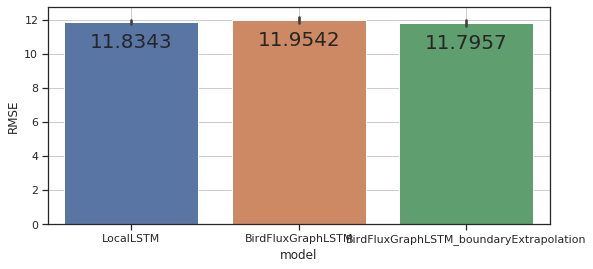

In [44]:
fig = utils.plot_average_errors(results, boundary=[], night_only=False, horizon=40)

### RMSE over data points with > 20 birds/km2

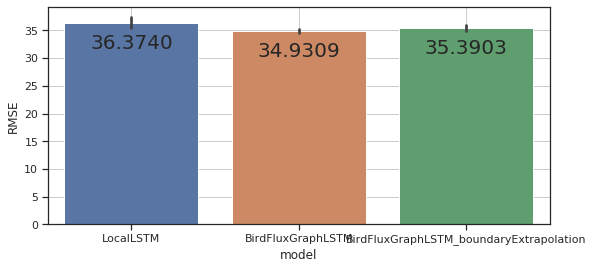

In [9]:
fig = utils.plot_average_errors(results, boundary=[], night_only=False, horizon=40, bird_thr=20)

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

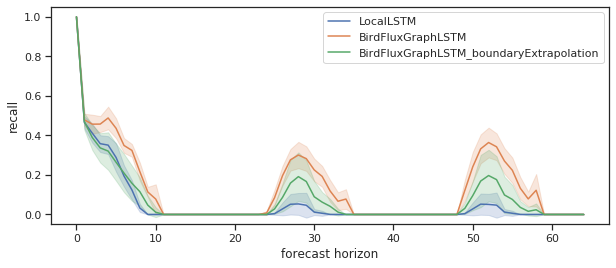

In [18]:
plot_classification_performance(results, thr=40, metric='recall')

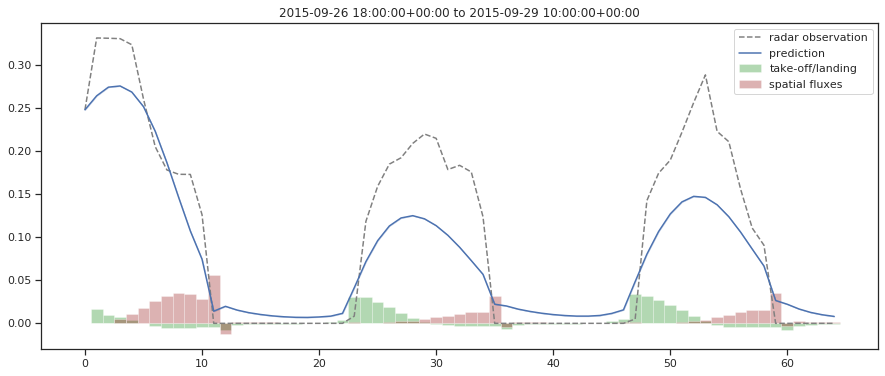

In [58]:
plot_example(results, bird_scales, 'BirdFluxGraphLSTM_boundaryExtrapolation', seqID=56, radar='defld', trial=5)

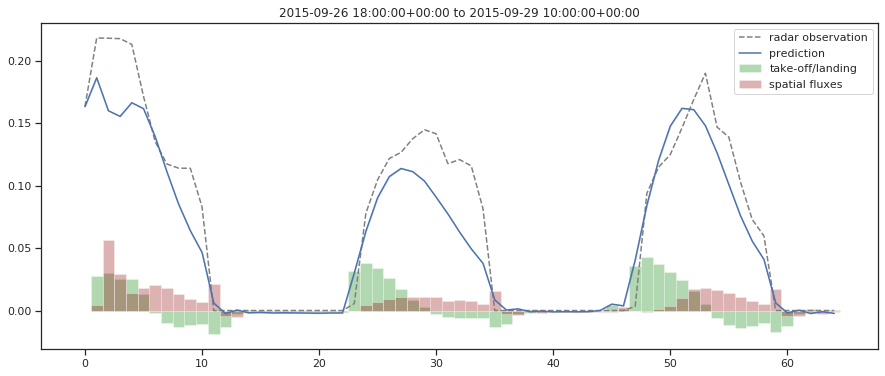

In [47]:
plot_example(results, bird_scales, 'BirdFluxGraphLSTM', seqID=56, radar='defld', trial=5)

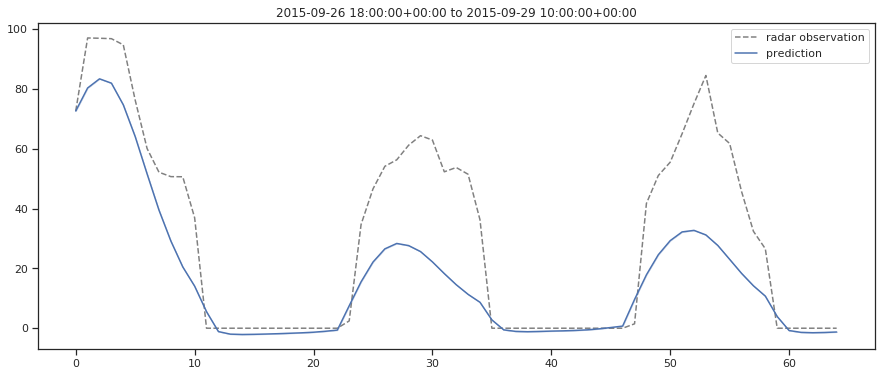

In [12]:
plot_example(results, bird_scales, 'LocalLSTM', seqID=56, radar='defld', trial=2)

torch.Size([37, 37, 4017]) torch.Size([37, 37, 4017])
RMSE = -4.5286881800166157e-08


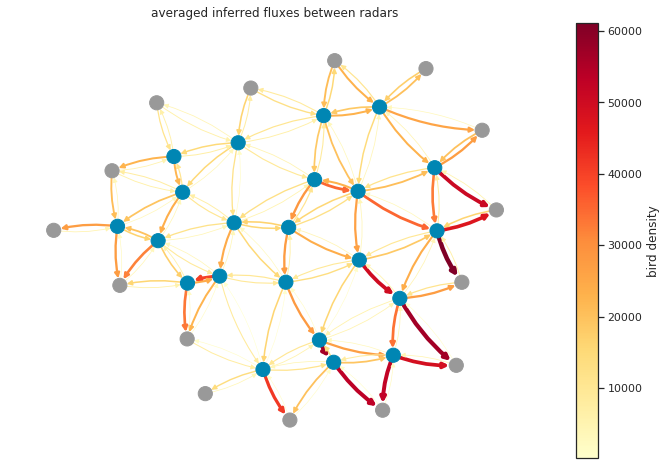

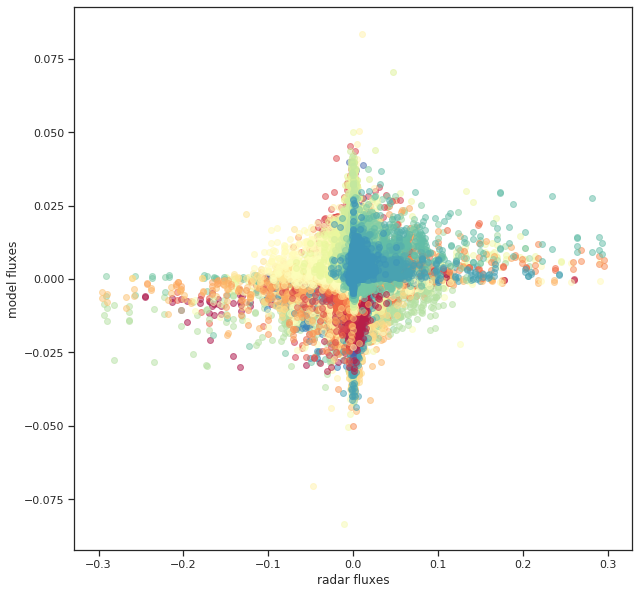

In [50]:
m = 'BirdFluxGraphLSTM_boundaryExtrapolation'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_fluxes(voronoi, G, fluxes[m][0], results[m], trial=2, encoder=1, bird_scale=bird_scales[m])

fig = compare_fluxes_radar(voronoi, G, results, fluxes[m][0], fluxes[m][1], trial=2, encoder=1, 
                           context=24, bird_scales=bird_scales, m=m, horizon=40)

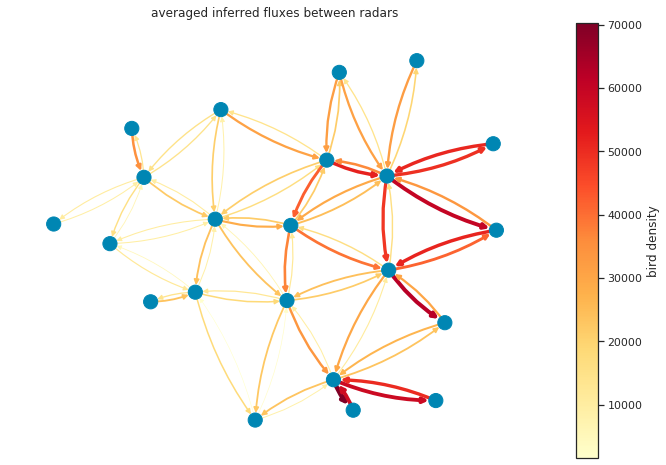

In [28]:
m = 'BirdFluxGraphLSTM'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_fluxes(voronoi, G, fluxes[m][0], results[m], trial=1, encoder=1, bird_scale=bird_scales[m])

In [9]:
# No encoder
models = [
    'BirdFluxGraphLSTM',
    'BirdFluxGraphLSTM_boundaryExtrapolation']
experiments = [
    'array_job_7864938',
    'array_job_7864931']
results_no_enc, bird_scales_no_enc, fluxes_no_enc, _, _ = load_results_new(models, experiments, base_dir)#, ext='_no_nights')

/home/fiona/birdMigration/results/radar/training+testing/BirdFluxGraphLSTM/array_job_7864938
5
/home/fiona/birdMigration/results/radar/training+testing/BirdFluxGraphLSTM_boundaryExtrapolation/array_job_7864931
5


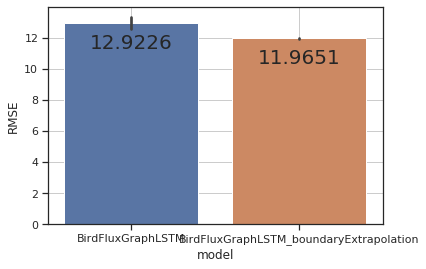

In [10]:
fig = utils.plot_average_errors(results_no_enc, boundary=[], night_only=False, horizon=40)

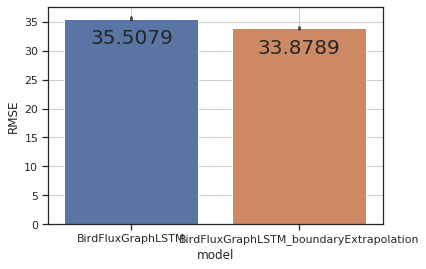

In [12]:
fig = utils.plot_average_errors(results_no_enc, boundary=[], night_only=False, horizon=40, bird_thr=20)

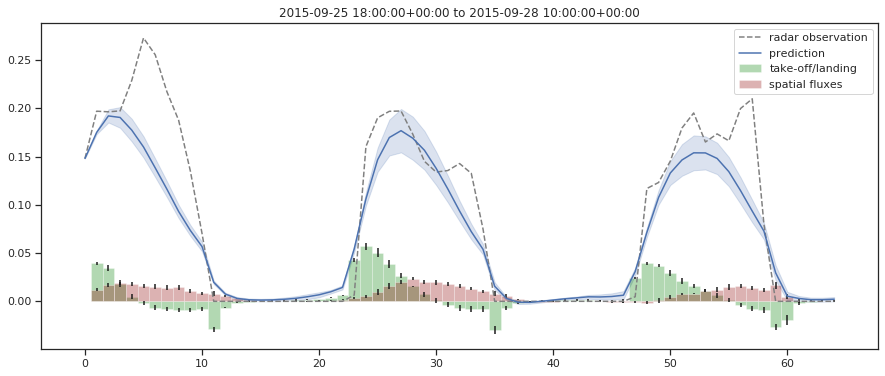

In [37]:
plot_example(results_no_enc, bird_scales_no_enc, 'BirdFluxGraphLSTM_boundaryExtrapolation', seqID=55, radar='dehnr', trial=None)

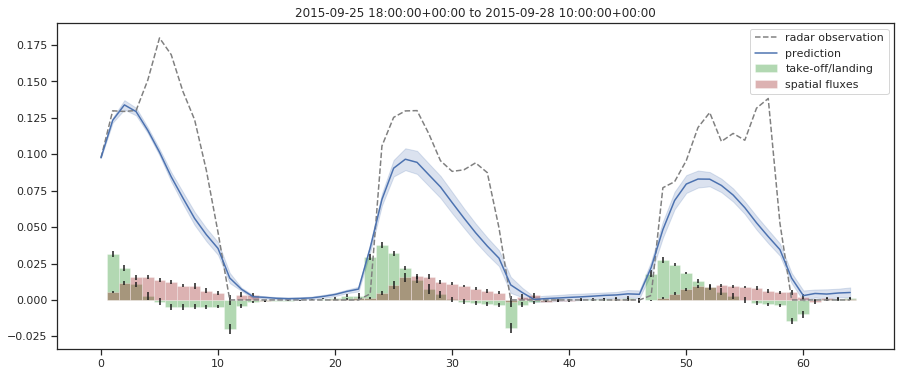

In [38]:
plot_example(results_no_enc, bird_scales_no_enc, 'BirdFluxGraphLSTM', seqID=55, radar='dehnr', trial=None)

torch.Size([37, 37, 4056]) torch.Size([37, 37, 4056])
RMSE = -1.2229732249124936e-07


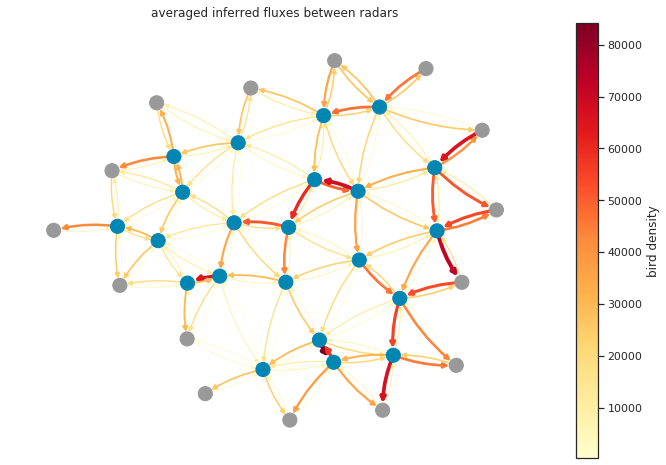

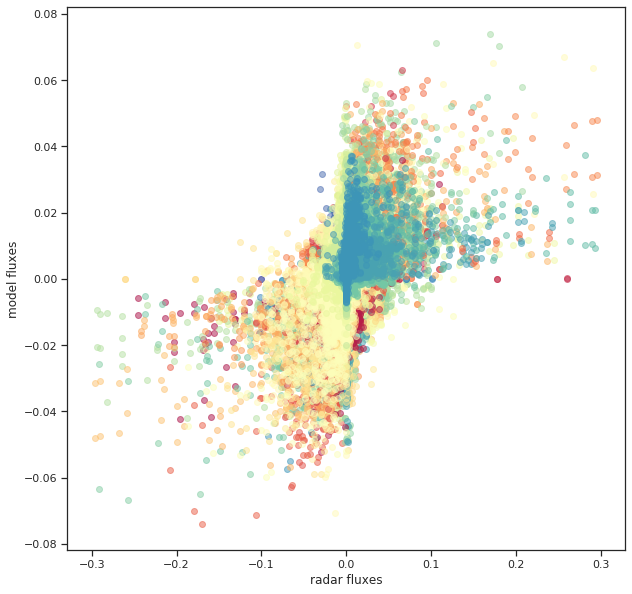

In [55]:
m = 'BirdFluxGraphLSTM_boundaryExtrapolation'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

trial = 0
G_new, fig = plot_fluxes(voronoi, G, fluxes_no_enc[m][0], results_no_enc[m], trial=trial, encoder=0, bird_scale=bird_scales_no_enc[m])

fig = compare_fluxes_radar(voronoi, G, results_no_enc, fluxes_no_enc[m][0], fluxes_no_enc[m][1], trial=trial, encoder=0, 
                           context=0, bird_scales=bird_scales_no_enc, m=m, horizon=40)